<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Защита персональных данных клиентов

В рамках проекта необходимо защитить данные клиентов страховой компании. 

**Цель проекта:** разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Ход исследования:**
 * Шаг 1: Загрузка и подготовка данных
 * Шаг 2: Ответ на вопрос и его обоснование: Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
 * Шаг 3: Предложение алгоритма преобразования данных
 * Шаг 4: Проверка алгоритма
 * Шаг 5: Выводы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

RANDOM_STATE = 12345

import warnings
warnings.simplefilter("ignore", ResourceWarning)
warnings.simplefilter("ignore", FutureWarning)

## Загрузка данных

Для первичного ознакомления с данными выведем первые 5 строк таблицы, а также получим информацию о таблице с помощью метода `info()`.

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Согласно документации к данным, в таблице содержатся:
* **Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.
* **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

Проверим таблицу на наличие дубликатов и пропусков, выведем информацию о таблице методом `describe()`

NULL: 0
Duplicates: 153
               Пол      Возраст      Зарплата  Члены семьи  Страховые выплаты
count  5000.000000  5000.000000   5000.000000  5000.000000        5000.000000
mean      0.499000    30.952800  39916.360000     1.194200           0.148000
std       0.500049     8.440807   9900.083569     1.091387           0.463183
min       0.000000    18.000000   5300.000000     0.000000           0.000000
25%       0.000000    24.000000  33300.000000     0.000000           0.000000
50%       0.000000    30.000000  40200.000000     1.000000           0.000000
75%       1.000000    37.000000  46600.000000     2.000000           0.000000
max       1.000000    65.000000  79000.000000     6.000000           5.000000 



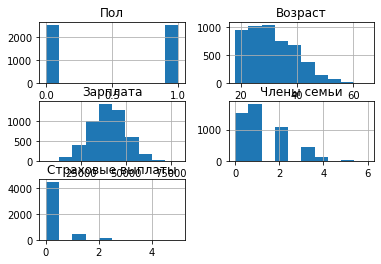

In [4]:
print('NULL:', df.isna().sum().sum())
print('Duplicates:', df.duplicated().sum())
print(df.describe(), '\n')
df.hist();

Удалим имеющиеся дубликаты

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
print(df.duplicated().sum())

0


Поскольку все данные в таблице целочисленны, приведём таблицу к типу `int`.

In [6]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                4847 non-null   int64
 1   Возраст            4847 non-null   int64
 2   Зарплата           4847 non-null   int64
 3   Члены семьи        4847 non-null   int64
 4   Страховые выплаты  4847 non-null   int64
dtypes: int64(5)
memory usage: 189.5 KB


Посмотрим на матрицу корреляций признаков:

Определитель матрицы попарных корреляций признаков: 0.57


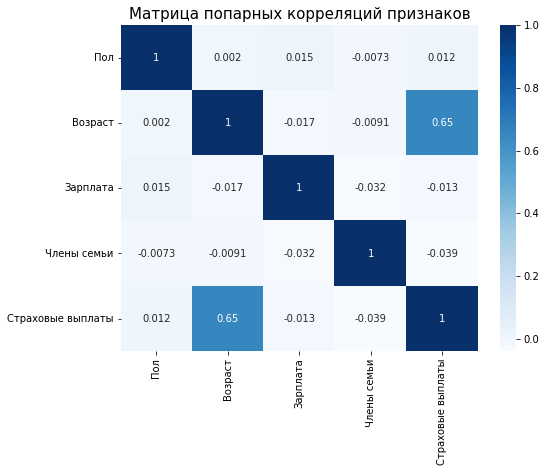

In [7]:
print('Определитель матрицы попарных корреляций признаков:', round(np.linalg.det(df.corr()), 2))


plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap="Blues", annot=True)
plt.title("Матрица попарных корреляций признаков", fontsize=15)
plt.show()

Наблюдается высокий коэффициент корреляции между возрастом и целевым признаков - количеством страховых выплат, мультиколлинеарности обнаружено не было.

## Умножение матриц

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? 

**Ответ: не изменится** 

**Обоснование:** 

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)


Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Вспомогательные свойства:
$$
(AB)^{-1} = B^{-1}A^{-1}
$$
$$
(AB)^T = B^{T}A^{T}
$$

Предсказания строятся следующим образом: 

$$
a = Xw = X (X^T X)^{-1} X^T y
$$

Умножим признаки $X$ на обратимую матрицу $P$. Тогда:

$$
a_1 = XPw = XP ((XP)^T XP)^{-1} (XP)^T y
$$

Воспользуемся вспомогательными свойствами обращения и транспонирования произведения матриц и раскроем скобки: 

$$
a_1 = XP (P^T X^T XP)^{-1} P^T X^T y = XP P^{-1} (P^T X^T X)^{-1} P^T X^T y = XP P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y = X (X^T X)^{-1}  X^T y
$$

Таким образом, $a_1 = a$, следовательно, значение предсказания не меняется при умножении матрицы признаков на обратимую матрицу.



## Алгоритм преобразования

**Алгоритм**

В качестве метода преобразования данных для защиты персональной информации можно воспользоваться умножением матрицы признаков на случайную обратимую квадратную матрицу.  
Соответственно, необходимо:
- случайным образом найти квадратную матрицу размерности $n*n$, где $n$ - количество признаков
- убедиться в обратимости матрицы - проверить, не равен ли определитель матрицы нулю; если равен - подбирать другую матрицу случайным образом, пока определитель не станет отличным от нуля
- умножить матрицу признаков на найденную случайную матрицу и обучить на преобразованных данных модель линейной регрессии

**Обоснование**

Умножение матрицы размером $m*n$ на матрицу $n*p$ даст матрицу $m*p$. Значит, умножение матрицы $m*n$ на матрицу $n*n$ даст, по-прежнему, матрицу $m*n$ - то есть размерность матрицы признаков не изменится.  
Не изменится в данном случае и качество линейной регрессии - это уже доказано выше.  
Для восстановления личной информации, то есть для обратного преобразования матрицы признаков, необходимо узнать обратную матрицу к нашей случайной матрице, что без знания самой случайной матрицы представляется невозможным или, по крайней мере, слишком ресурсозатратным.

## Проверка алгоритма

Вывделим матрицу признаков и столбец целевого признака.

In [8]:
features = df.drop(['Страховые выплаты'], axis=1)
target = df['Страховые выплаты']

print(features.shape)
print(target.shape)

(4847, 4)
(4847,)


Напишем функцию `split_scale`, с помощью которой будем производить деление выборок на обучающую и валидационную, а также масштабирование признаков.

In [9]:
def split_scale(features, target):
    """
    Функция принимает на вход таблицу признаков features и столбец целевого признака target, 
    и возвращает тренировочную и валидационную выборку для features и target в соотношении 75:25
    """
    
    # разделим выборку на две части: обучающую и тестовую
    (features_train, features_valid, 
     target_train, target_valid) = train_test_split(features, 
                                                   target,
                                                   test_size=.25,
                                                   random_state=RANDOM_STATE)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)

    return (features_train, 
            features_valid,
            target_train, 
            target_valid)

Создадим функцию `linear_regression`, с помощю которой будем обучать модель линейной регрессии и выполнять предсказания для валидационной выборки.

In [10]:
def linear_regression(features_train, features_valid, target_train, target_valid):
    """
    Функция принимает на вход тренировочную и валидационную выборку, обучает модель линейной регрессии 
    и возвращает предсказания и зачение R2 для валидационной выборки
    """
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_valid = pd.Series(predicted_valid)
    r2 = r2_score(target_valid, predicted_valid)
    
    
    return (predicted_valid, r2)

Создадим функцию для поиска случайной обратимой матрицы.

In [11]:
def rand_matrix(shape):
    matrix = np.random.rand(shape, shape)
    if np.linalg.det(matrix) != 0:
        return matrix
    else: matrix = rand_matrix(shape)

С помощью функции создадим матрицу 4*4, удостовреимся, что она обратима.

In [12]:
matrix = rand_matrix(4)
print('Исходная матрица:')
print(matrix)
print()
print('Обратная матрица')
print(np.linalg.inv(matrix))

Исходная матрица:
[[0.90179079 0.57485871 0.26199002 0.20587733]
 [0.723242   0.19623096 0.91097241 0.9994723 ]
 [0.14400466 0.97033553 0.68193359 0.37190471]
 [0.99439654 0.51006661 0.32917925 0.25941848]]

Обратная матрица
[[ -1.85295807  -0.23017464  -0.38494201   2.90918745]
 [  7.19322538   0.15942826   0.24552808  -6.67484904]
 [-19.49628264  -1.58606661   2.13296579  18.52532701]
 [ 17.69851867   2.58141235  -1.71375132 -17.67962583]]


Преобразуем матрицу признаков: умножим её на найденную случайную матрицу.

In [13]:
features_transformed = features.dot(matrix)

print('Исходная матрица признаков\n', features.head(), '\n')
print('Преобразованная матрица признаков\n', features_transformed.head())

Исходная матрица признаков
    Пол  Возраст  Зарплата  Члены семьи
0    1       41     49600            1
1    0       46     38000            1
2    0       29     21000            0
3    0       21     41700            2
4    1       28     26100            0 

Преобразованная матрица признаков
              0             1             2             3
0  7174.180345  48137.772596  33861.847269  18487.917500
1  5506.440685  36882.286764  25955.710458  14178.614296
2  3045.071920  20382.736791  14347.023661   7838.983702
3  6022.171281  40468.132512  28456.419623  15529.934351
4  3779.674245  25331.826613  17824.236005   9734.904151


Обучим модель линейной регрессии на двух таблицах признаков.

In [14]:
# обучение модели на исходных признаках
(features_train, 
 features_valid, 
 target_train,
 target_valid) = split_scale(features, target)

predicted_valid, r2 = linear_regression(features_train,
                                             features_valid, 
                                             target_train,
                                             target_valid)
print('R2 модели линейной регрессии до преобразования признаков:', r2)

R2 модели линейной регрессии до преобразования признаков: 0.423077276158367


In [15]:
# обучение модели на преобразованных признаках
(features_train_transformed, 
 features_valid_transformed, 
 target_train_transformed,
 target_valid_transformed) = split_scale(features_transformed, target)

predicted_valid_transformed, r2_transformed = linear_regression(features_train_transformed,
                                             features_valid_transformed, 
                                             target_train_transformed,
                                             target_valid_transformed)
print('R2 модели линейной регрессии после преобразования признаков:', r2_transformed)

R2 модели линейной регрессии после преобразования признаков: 0.42307727615855184


In [16]:
print('Разница между значениями R2 для двух методов:', r2_transformed - r2)

Разница между значениями R2 для двух методов: 1.8485213360008856e-13


Итак, по метрике R2 видно, что если изменения в предсказаниях модели линейной регрессии при преобразовании принаков имеются, то они совершенно незначительны и обусловлены, скорее всего, процедурой масштабирования преобразованных признаков.

## Выводы

В рамках проекта необходимо было разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Для осуществления посталвенной цели были выполнены следующие задачи:

- данные были загружены и обработаны
- отсутсвие изменений в предсказаниях модели линейной регрессии при умножении матрицы признаков на случайную обратимую матрицу было доказано теоретически
- предложен, реализован и проверен алгоритм преобразования данных, с помощью метрики R2 было проверено, что качество линейной регрессии не меняется при преобразовании матрицы признаков.